In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# tower location & domain number to analyze
sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 
            'les200m': ['c1.d03', d03_wrf_dt], 
            'les40m': ['c1.d04', d04_wrf_dt]}

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
co2flx25m_ncs = obs_dir+'sgpco2flx25mC1.b1/*.nc'
# obs bowen_ratio is nan...!

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

co2flx4m_ncs = obs_dir+'sgpco2flx4mC1.b1/*.nc'
co2flx4m = xr.open_mfdataset(co2flx4m_ncs)
co2flx4m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ebbre13_ncs = obs_dir+'sgp30ebbrE13.b1/*.nc'
ebbre13 = xr.open_mfdataset(ebbre13_ncs)
ebbre13_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ecore14_ncs = obs_dir+'sgp30ecorE14.b1/*.cdf'
ecore14 = xr.open_mfdataset(ecore14_ncs)
ecore14_dict = {'hfx': ['h', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['lv_e', r'latent heat flux (W m$^{-2}$)']}

# 1 obs height in m, to match wrf's heights
share_height = [4, 25]

## combo fluxes

In [4]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def plot_flux(eval_date, row, model):

    date_col = data_dir_df[eval_date]
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
    wrf_tower = Tower(c1_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

    wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))
    
    # resample wrf every 30 minute to match obs frequency
    # obs are 30-minute averages
    wrf_ds = wrf_ds.resample(datetime='30min').mean()

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))
    ebbre13_ds = ebbre13.sel(time=slice(eval_date, eval_date))
    ecore14_ds = ecore14.sel(time=slice(eval_date, eval_date))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf', c='k', linewidth=1.5)

        co2flx4m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        ebbre13_ds[var[1][0]] = ebbre13[var[1][0]].where(ebbre13['qc_'+var[1][0]] == 0)
        ax_i.plot(ebbre13_ds['time'], -ebbre13_ds[var[1][0]], label='ebbre13')

    for var, ax_i in zip(ecore14_dict.items(), ax): 

        ecore14_ds[var[1][0]] = ecore14[var[1][0]].where(ecore14['qc_'+var[1][0]] == 0)
        ax_i.plot(ecore14_ds['time'], ecore14_ds[var[1][0]], label='ecore14')

    for wrf_var, var in co2flx25m_dict.items(): 

        co2flx25m_ds[var[0]] = co2flx25m[var[0]].where(co2flx25m['qc_'+var[0]] <= 3)
        ax[0].plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.set_title(var[1][0]+': '+row+'\n'+model+' vs obs: '+eval_date)
        ax_i.set_ylabel(var[1][1])
        ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)
        ax_i.legend()

        plt.savefig('plots_03c/combo_'+eval_date+'_'+row+'_'+model+'_fluxes.pdf')

    plt.show()
    
    return wrf_ds

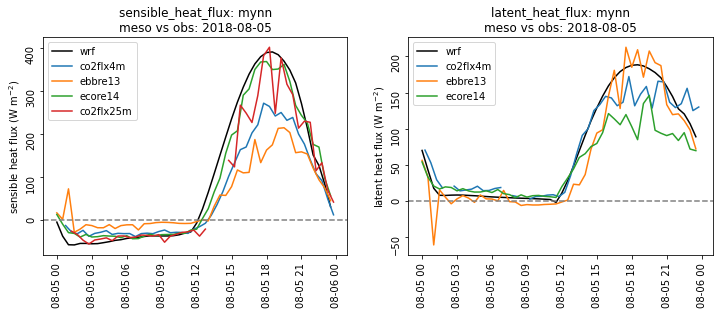

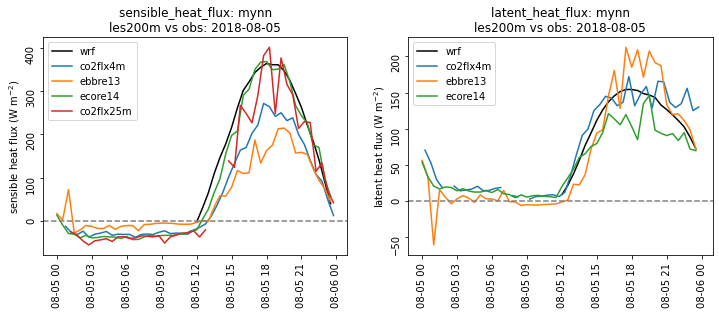

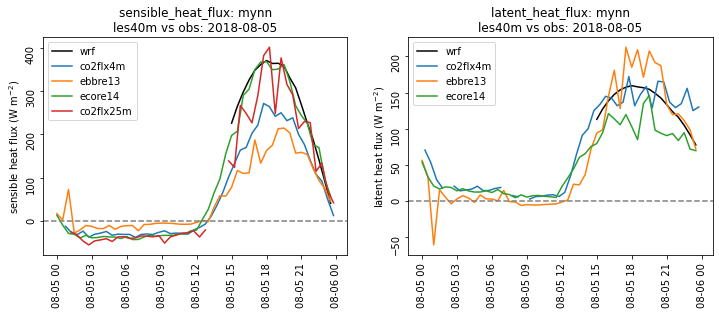

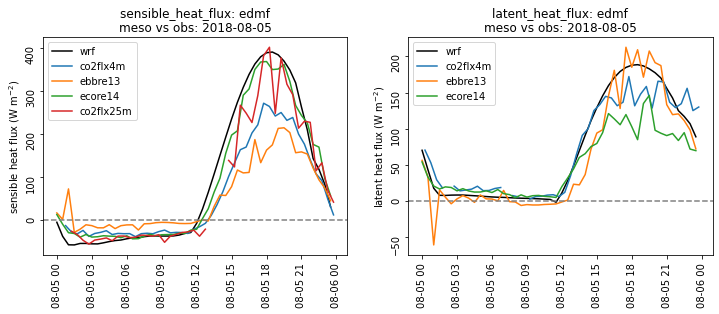

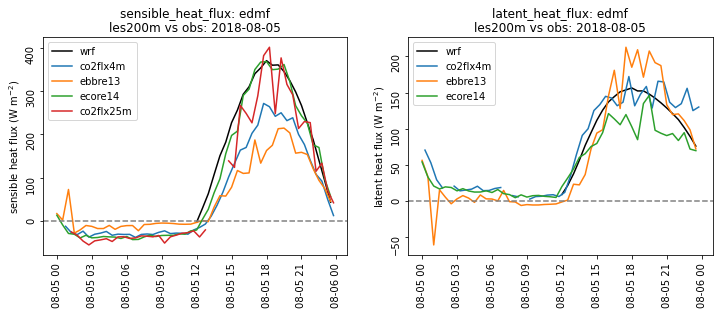

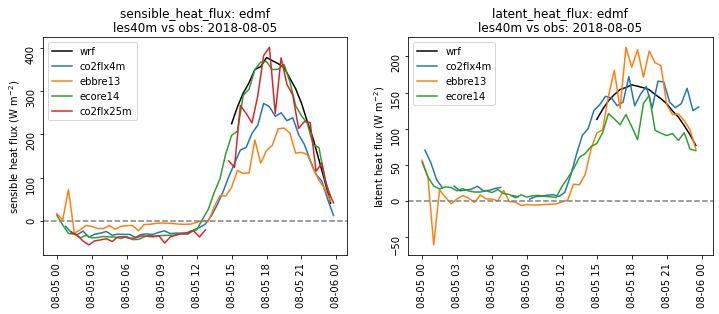

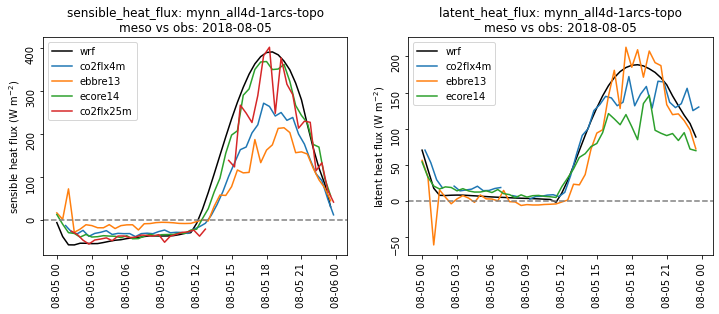

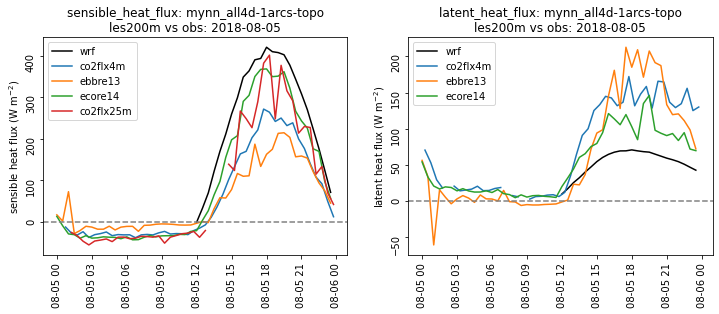

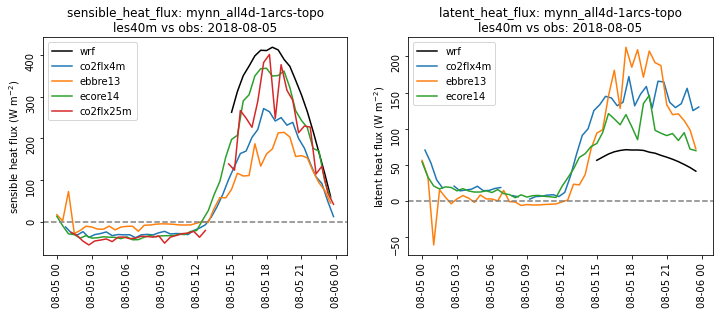

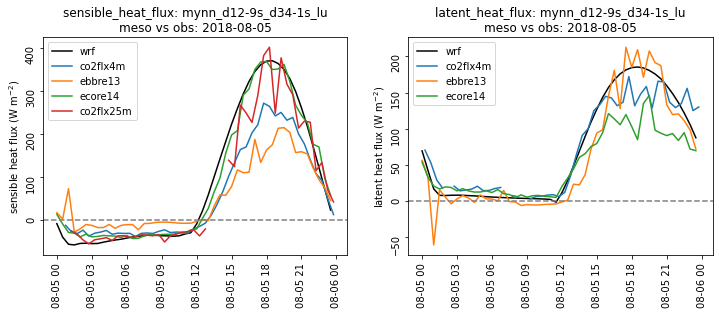

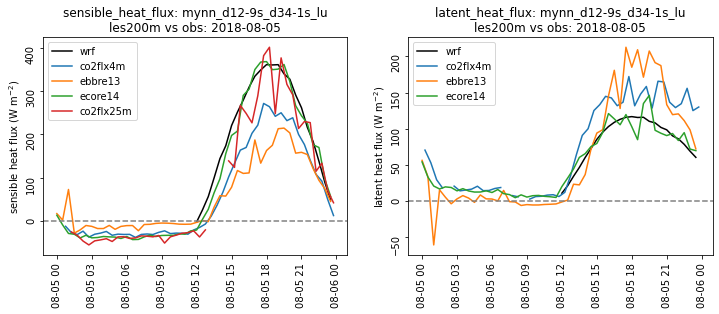

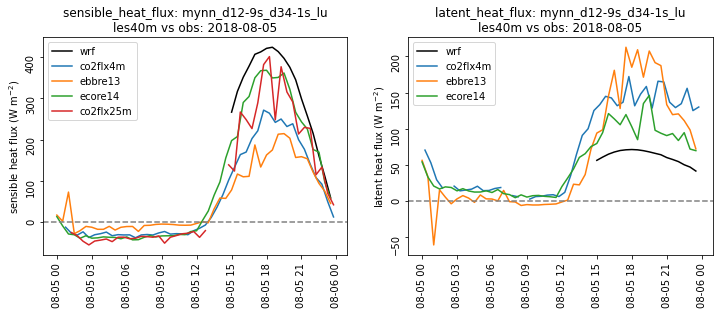

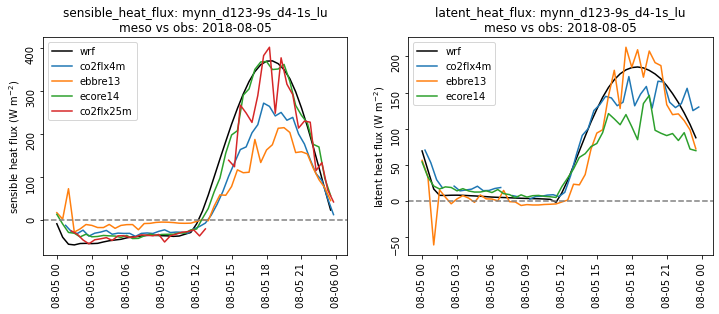

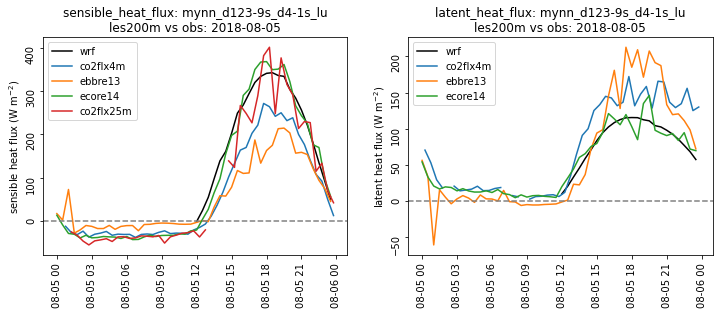

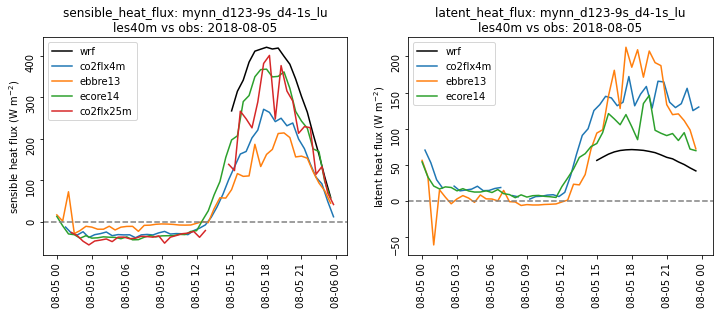

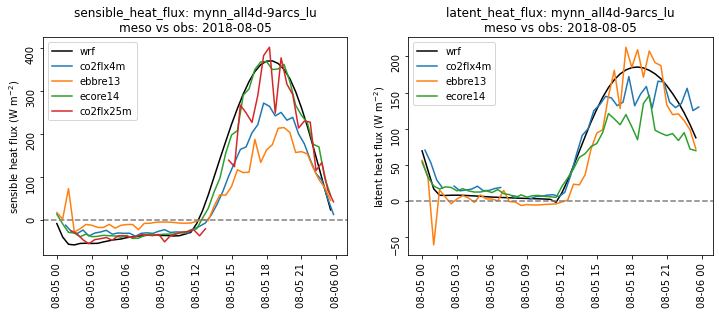

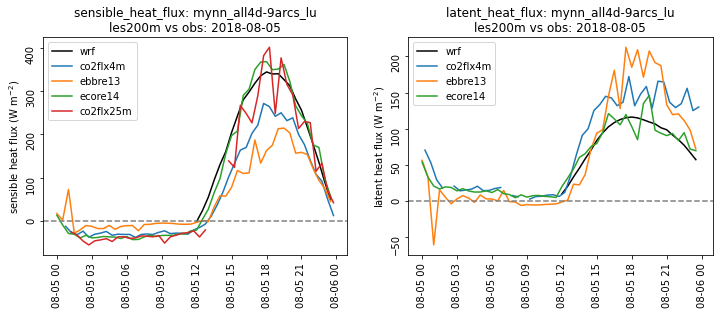

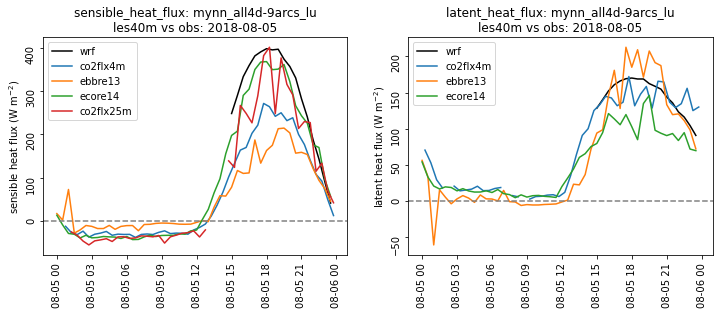

In [5]:
eval_date = '2018-08-05'

for row in ['mynn', 'edmf', 'mynn_all4d-1arcs-topo', 'mynn_d12-9s_d34-1s_lu', 
            'mynn_d123-9s_d4-1s_lu', 'mynn_all4d-9arcs_lu']: 
# for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

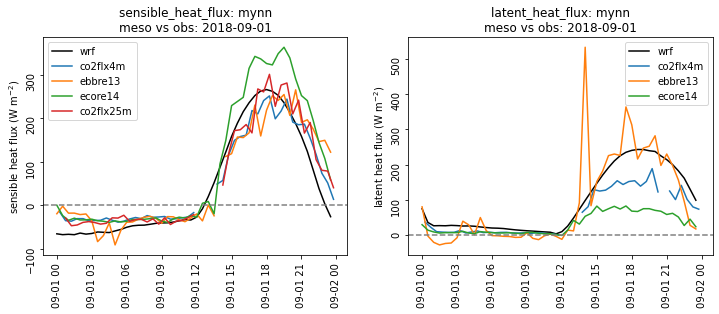

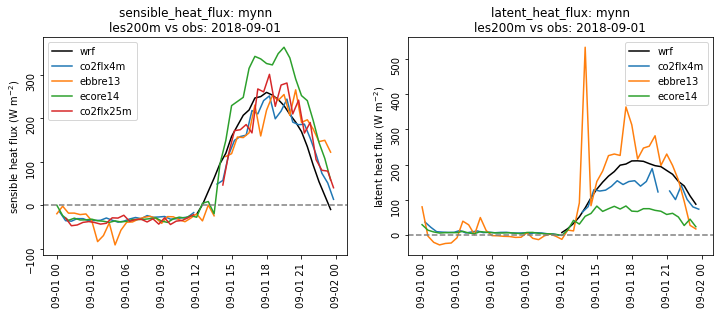

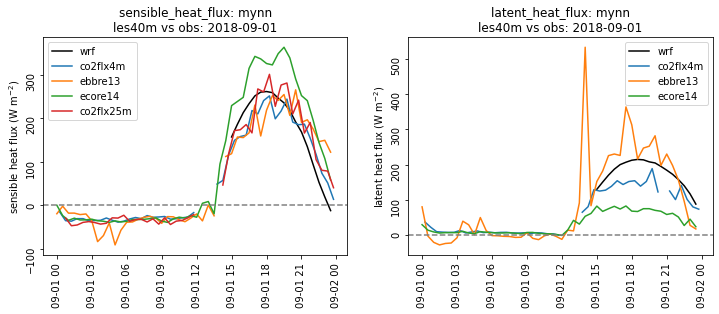

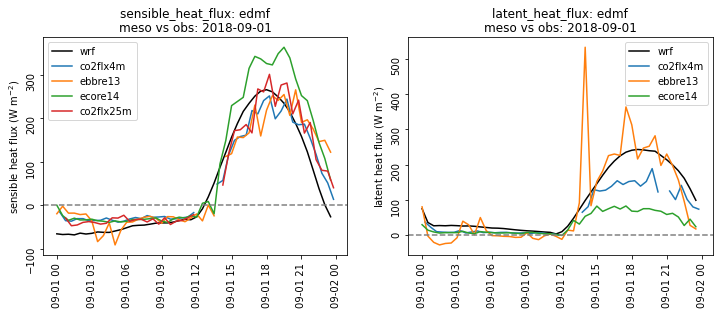

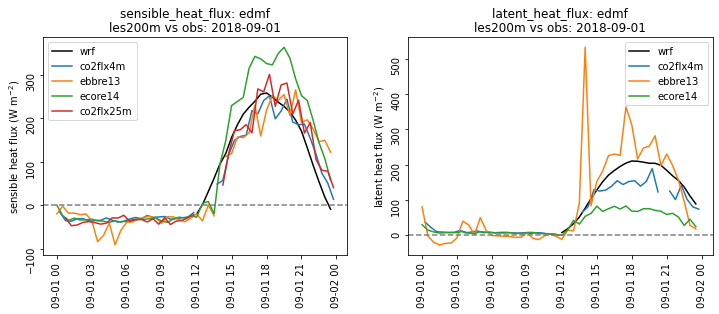

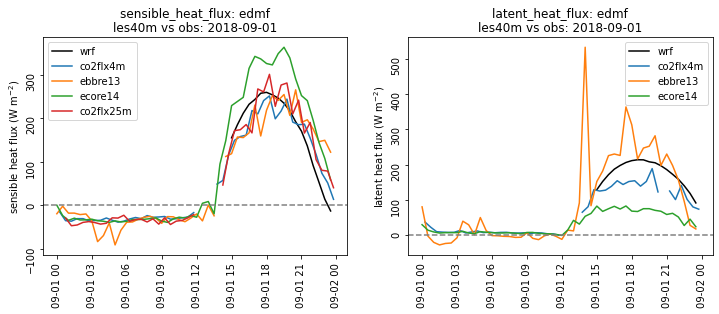

In [6]:
eval_date = '2018-09-01'

for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

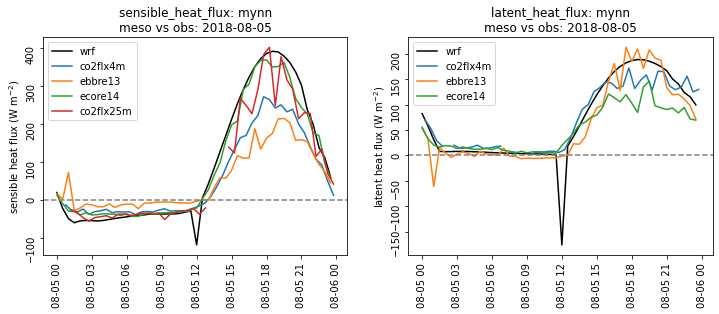

In [18]:
eval_date = '2018-08-05'
model = 'meso'

for row in ['mynn']: 
# for row in ['mynn', 'edmf']: 
#     for model in sim_dict.keys():
    plot_flux(eval_date, row, model)

## 1 to 1 wrf-obs comparison

In [11]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def plot_flux(eval_date, row, model):

    date_col = data_dir_df[eval_date]

#     wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
#     c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
    wrf_tower = Tower(c1_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

    wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))

    for wrf_var, var in co2flx25m_dict.items(): 
        
#         print(wrf_ds['datetime'])
#         print(co2flx25m_ds['time'])

        co2flx25m_ds[var[0]] = co2flx4m[var[0]].where(co2flx4m['qc_'+var[0]] <= 3)

        plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var], label='wrf')
        plt.plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

        plt.title(var[0]+': '+row+' '+model+' vs '+co2flx25m_ds.platform_id+': '+eval_date)
        plt.ylabel(var[1])
        plt.axhline(color='grey', linestyle='--')
        plt.tick_params(labelrotation=90)
        plt.legend()

#         plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+wrf_var+'25m.pdf')

        plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 
        
        co2flx25m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)

        ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf')
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

        ax_i.set_title(var[1][0]+':\n'+row+' '+model+' vs '
                       +co2flx4m_ds.platform_id+': '+eval_date)
        ax_i.set_ylabel(var[1][1])
        ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)
        ax_i.legend()

    p2_txt = '_'.join([str(elem) for elem in list(co2flx4m_dict.keys())])    

#     plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+p2_txt+'4m.pdf')

    plt.show()
    
    return wrf_ds

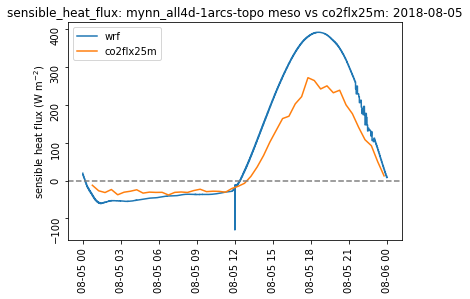

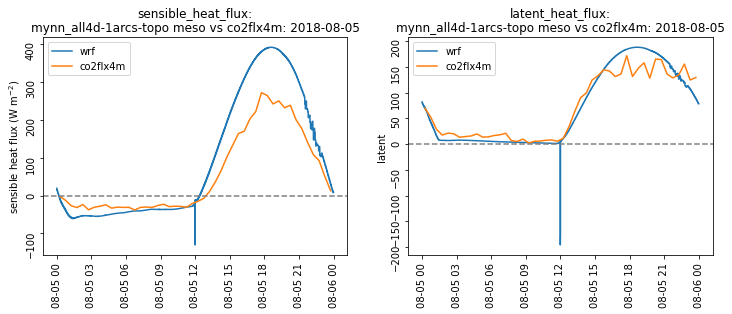

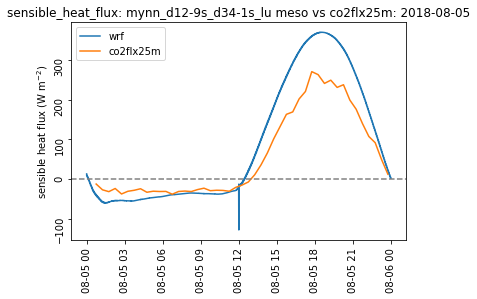

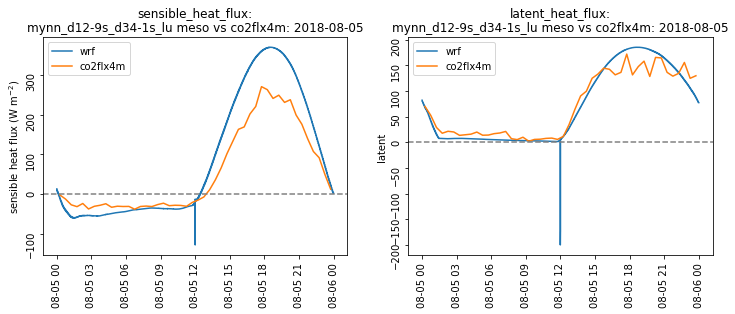

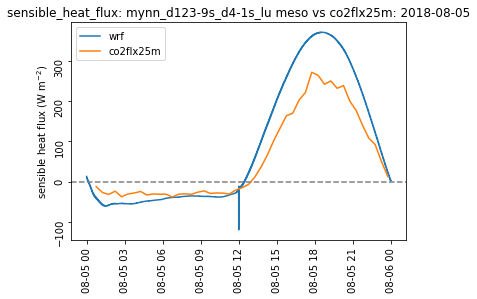

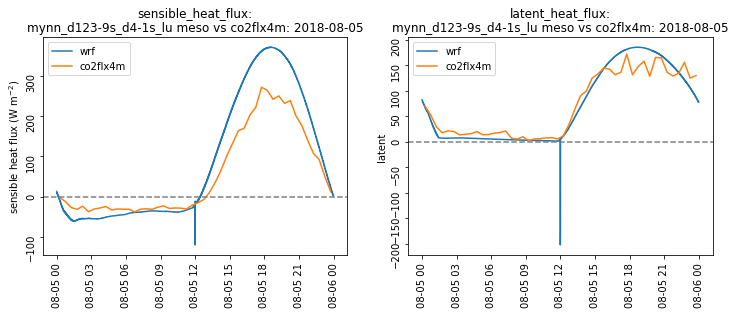

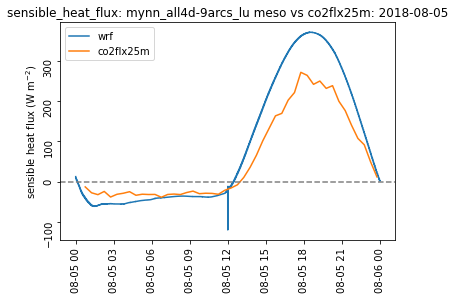

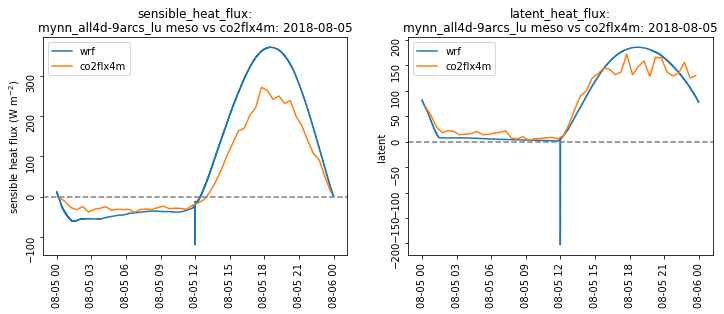

In [12]:
eval_date = '2018-08-05'
model = 'meso'
# for row in ['mynn', 'edmf', 'mynn_1arcs']: 
for row in ['mynn_all4d-1arcs-topo', 'mynn_d12-9s_d34-1s_lu', 
            'mynn_d123-9s_d4-1s_lu', 'mynn_all4d-9arcs_lu']: 
# for row in ['mynn', 'edmf']: 
#     for model in sim_dict.keys():
    plot_flux(eval_date, row, model)

In [8]:
sim_dict.keys()

dict_keys(['meso', 'les200m', 'les40m'])

In [27]:
eval_date = '2018-08-05'
row = 'mynn'
model = 'meso'

In [35]:
ebbre13_ncs = obs_dir+'sgp30ebbrE13.b1/*.nc'
ebbre13 = xr.open_mfdataset(ebbre13_ncs)
ebbre13_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ecore14_ncs = obs_dir+'sgp30ecorE14.b1/*.cdf'
ecore14 = xr.open_mfdataset(ecore14_ncs)
ecore14_dict = {'hfx': ['h', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['lv_e', r'latent heat flux (W m$^{-2}$)']}

ebbre13_ds = ebbre13.sel(time=slice(eval_date, eval_date))
ecore14_ds = ecore14.sel(time=slice(eval_date, eval_date))

# obs
co2flx25m_ncs = obs_dir+'sgpco2flx25mC1.b1/*.nc'
# obs bowen_ratio is nan...!

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

co2flx4m_ncs = obs_dir+'sgpco2flx4mC1.b1/*.nc'
co2flx4m = xr.open_mfdataset(co2flx4m_ncs)
co2flx4m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

# 1 obs height in m, to match wrf's heights
share_height = [4, 25]

co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))

In [28]:
date_col = data_dir_df[eval_date]

#     wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
#     c1_mynn_file_path = wrf_mynn_dir+c1_file_name

wrf_dir = wrf_runs_dir+date_col[row]+'/'
c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
wrf_tower = Tower(c1_file_path)

# # simulation start time
wrf_start = date_col['wrf_start']

wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))

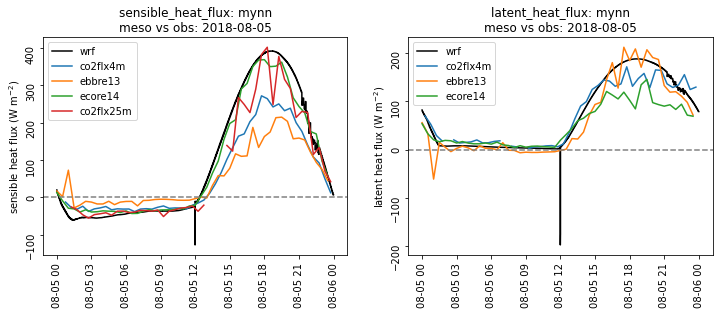

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for var, ax_i in zip(co2flx4m_dict.items(), ax): 
    
    ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf', c='k')

    co2flx4m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)
    ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

for var, ax_i in zip(ebbre13_dict.items(), ax): 

    ebbre13_ds[var[1][0]] = ebbre13[var[1][0]].where(ebbre13['qc_'+var[1][0]] == 0)
    ax_i.plot(ebbre13_ds['time'], -ebbre13_ds[var[1][0]], label='ebbre13')

for var, ax_i in zip(ecore14_dict.items(), ax): 

    ecore14_ds[var[1][0]] = ecore14[var[1][0]].where(ecore14['qc_'+var[1][0]] == 0)
    ax_i.plot(ecore14_ds['time'], ecore14_ds[var[1][0]], label='ecore14')
    
for wrf_var, var in co2flx25m_dict.items(): 

    co2flx25m_ds[var[0]] = co2flx25m[var[0]].where(co2flx25m['qc_'+var[0]] <= 3)
    ax[0].plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')
    
for var, ax_i in zip(co2flx4m_dict.items(), ax): 

    ax_i.set_title(var[1][0]+': '+row+'\n'+model+' vs obs: '+eval_date)
    ax_i.set_ylabel(var[1][1])
    ax_i.axhline(color='grey', linestyle='--')
    ax_i.tick_params(labelrotation=90)
    ax_i.legend()

#     plt.savefig('plots_03c/combo_'+eval_date+'_'+row+'_'+model+'_flux.pdf')

plt.show()

In [2]:
co2flx4m

<xarray.Dataset>
Dimensions:                                        (bound: 2, time: 2880)
Coordinates:
  * time                                           (time) datetime64[ns] 2018...
Dimensions without coordinates: bound
Data variables:
    base_time                                      (time) datetime64[ns] 2018...
    time_offset                                    (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
    time_bounds                                    (time, bound) datetime64[ns] dask.array<chunksize=(48, 2), meta=np.ndarray>
    momentum_flux                                  (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_momentum_flux                               (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    random_error_momentum_flux                     (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    sensible_heat_flux                             (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_sensible_heat_flux                          (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    random_error_sensible_heat_flux                (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    latent_heat_flux                               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_latent_heat_flux                            (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    random_error_latent_heat_flux                  (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_flux                                       (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_co2_flux                                    (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    random_error_co2_flux                          (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_flux                                       (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_h2o_flux                                    (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    random_error_h2o_flux                          (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_molar_density                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_mole_fraction                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_mixing_ratio                               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_time_lag                                   (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    co2_time_lag_state                             (time) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_molar_density                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_mole_fraction                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_mixing_ratio                               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_time_lag                                   (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_time_lag_state                             (time) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    sonic_temperature                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    air_temperature                                (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    air_pressure                                   (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    air_density                                    (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    air_heat_capacity                              (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    air_molar_volume                               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    

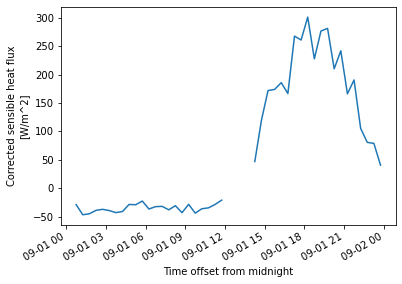

In [13]:
eval_date = '2018-09-01'

co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))

co2flx25m_ds['sensible_heat_flux'].where(co2flx25m_ds['qc_sensible_heat_flux'] <= 3).plot()

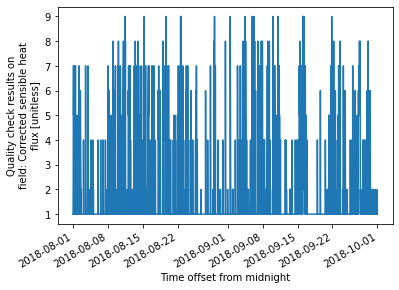

In [6]:
co2flx4m['qc_sensible_heat_flux'].plot()

In [3]:
data_dir_df

,2018-08-05,2018-09-01
mynn,l1_0805m,l3_0901m
edmf,l2_0805e,l4_0901e
mynn_1arcs,l5_0805m,NaN
wrf_start,8/4/18 12:00,8/31/18 12:00


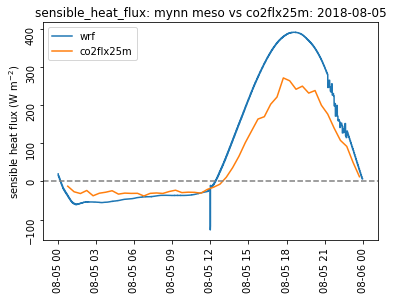

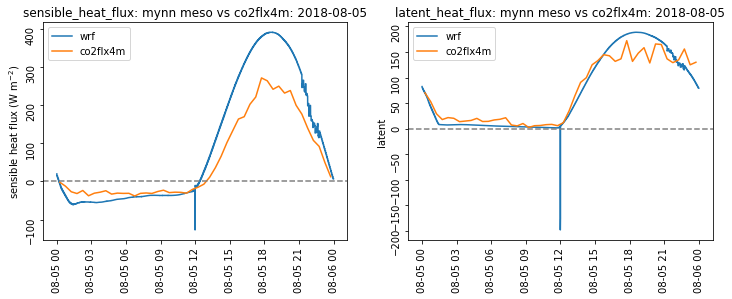

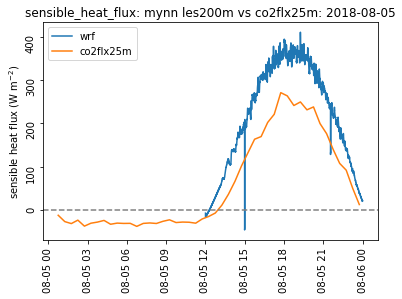

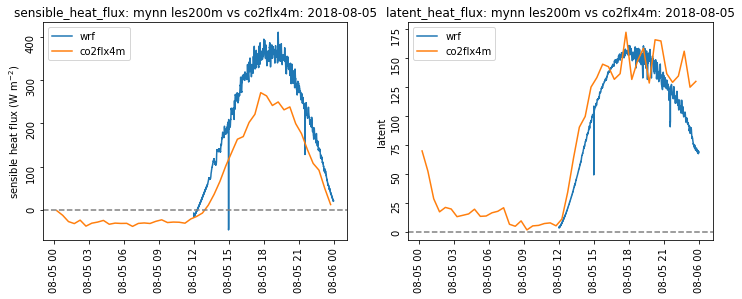

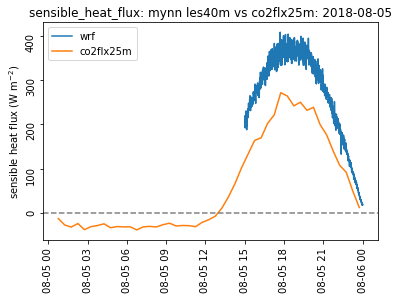

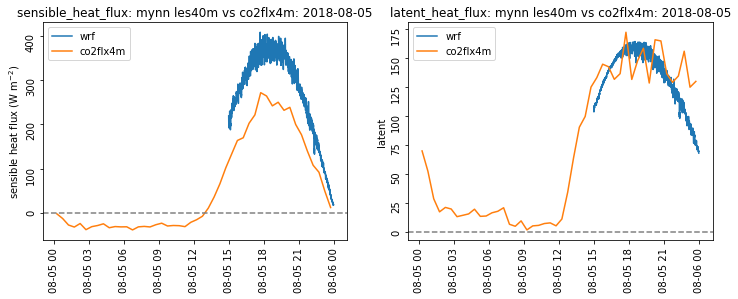

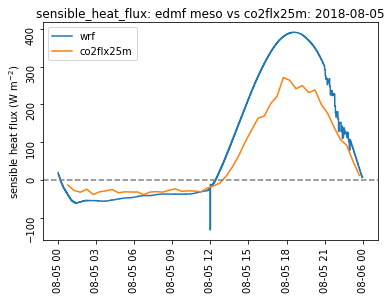

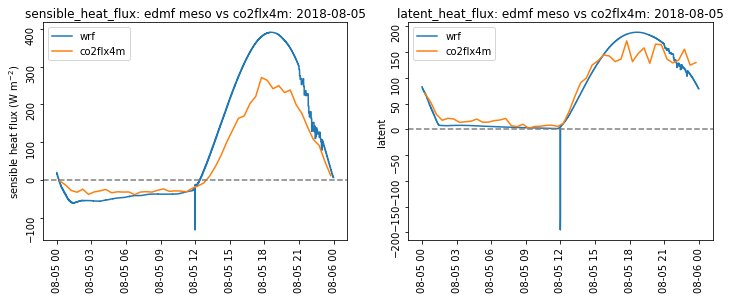

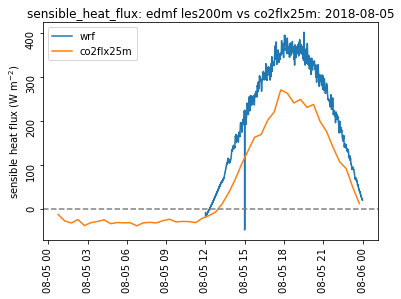

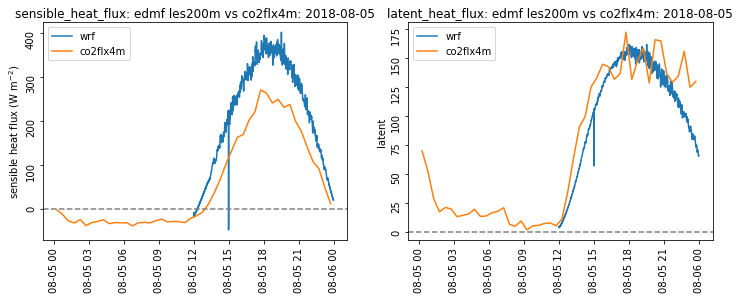

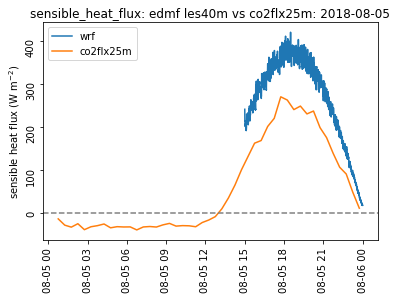

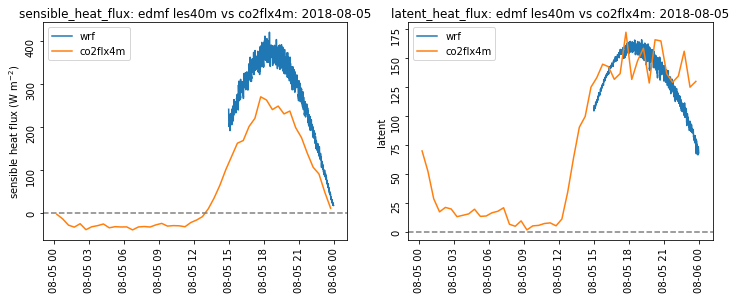

In [3]:
eval_date = '2018-08-05'
# for row in ['mynn', 'edmf', 'mynn_1arcs']: 
for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

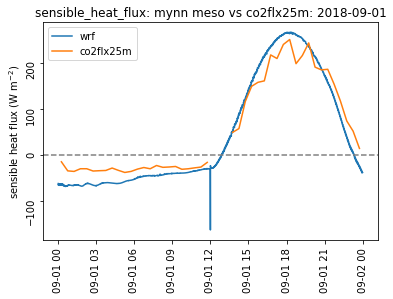

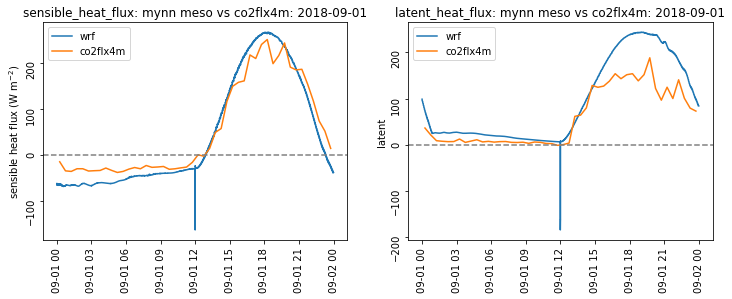

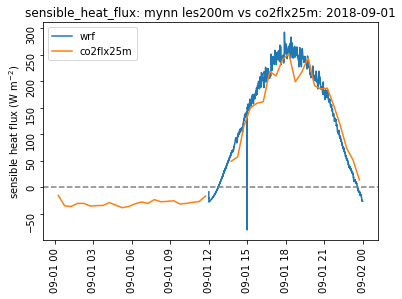

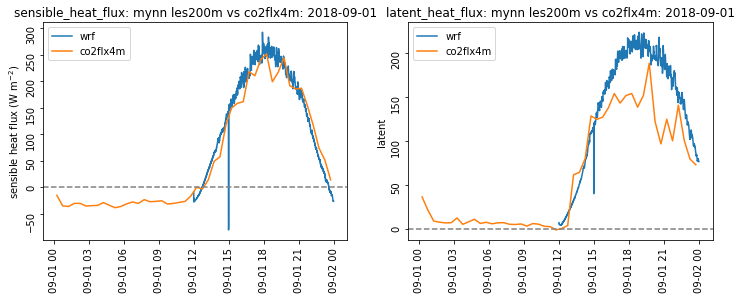

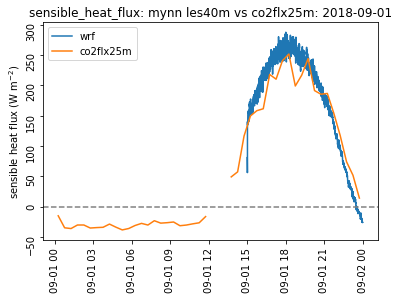

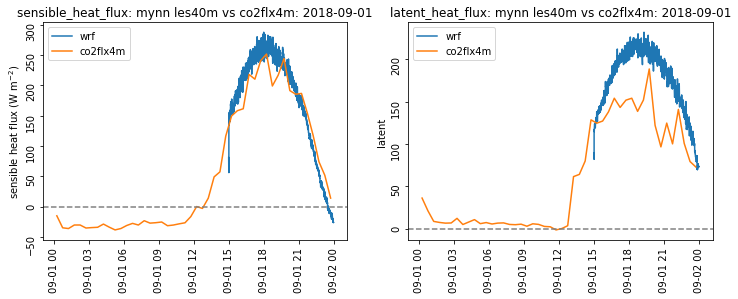

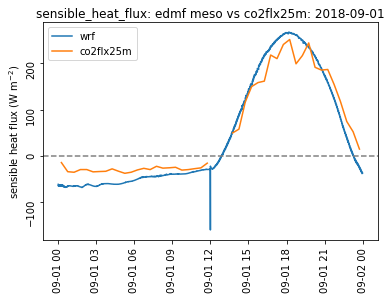

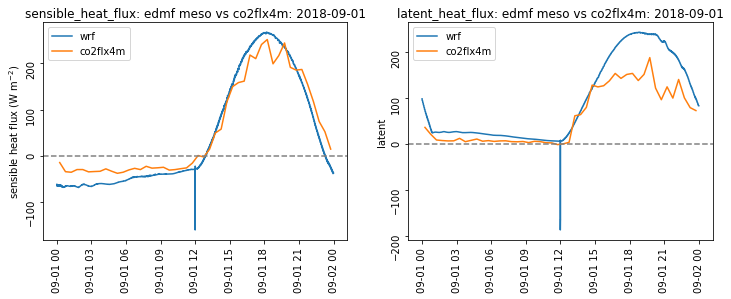

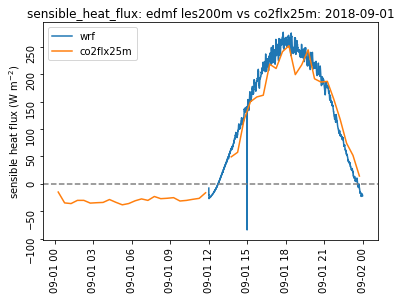

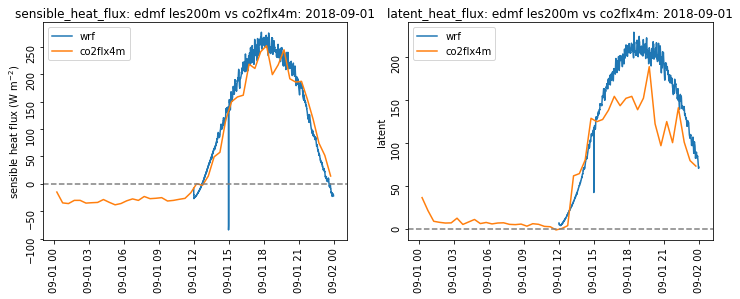

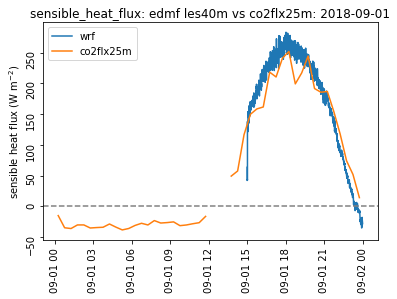

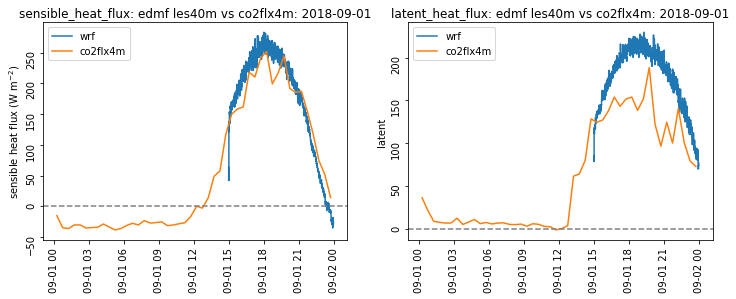

In [4]:
eval_date = '2018-09-01'
for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

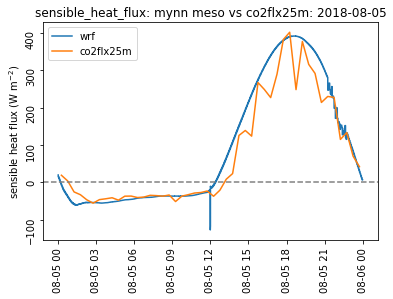

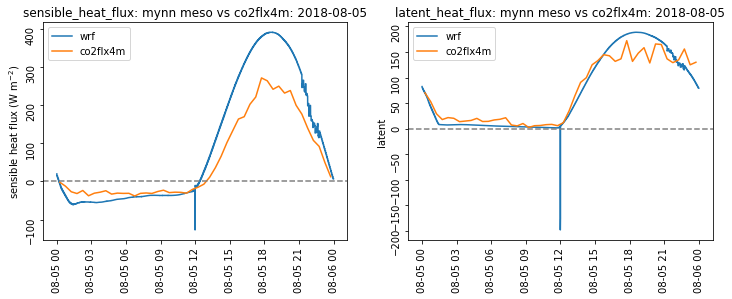

In [18]:
eval_date = '2018-08-05'
mm = plot_flux(eval_date, 'mynn', 'meso')

In [29]:
# checked TS file, hfx IS that odd... starting the inner domain causes the problem??
mm['hfx'].sel(datetime=slice('2018-08-05T11:58', '2018-08-05T12:02'))

<xarray.DataArray 'hfx' (datetime: 30, station: 1)>
array([[ -19.49589],
       [ -19.5514 ],
       [ -19.5992 ],
       [ -19.64952],
       [ -19.70514],
       [ -19.7481 ],
       [ -19.79265],
       [ -19.84283],
       [-127.10773],
       [-116.67835],
       [-117.7855 ],
       [-118.25767],
       [-117.96146],
       [ -10.34582],
       [ -11.78806],
       [ -12.14938],
       [ -12.42465],
       [ -12.70046],
       [ -12.95655],
       [ -13.19956],
       [ -13.43283],
       [ -13.62916],
       [ -13.83105],
       [ -14.02229],
       [ -14.21196],
       [ -14.37398],
       [ -14.54752],
       [ -14.70349],
       [ -14.85901],
       [ -15.00641]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T11:58:00 ... 2018-08-05T12...
  * station   (station) <U4 'z.c1'